Aggregated data with driving score and category saved to ../data/driver_aggregated_data_with_category.csv.


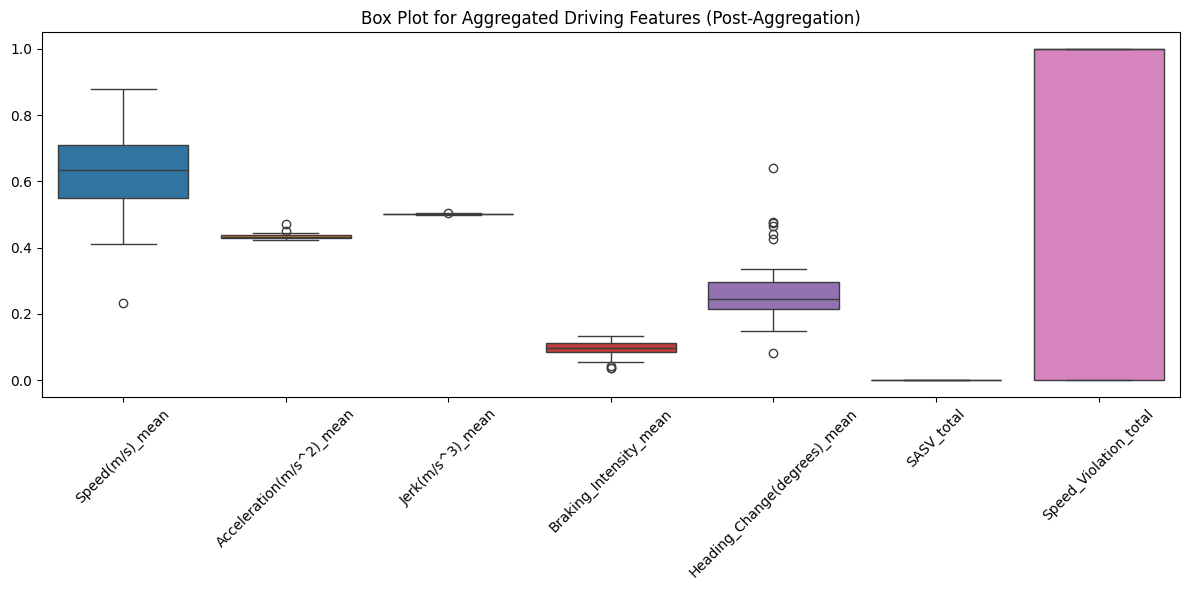

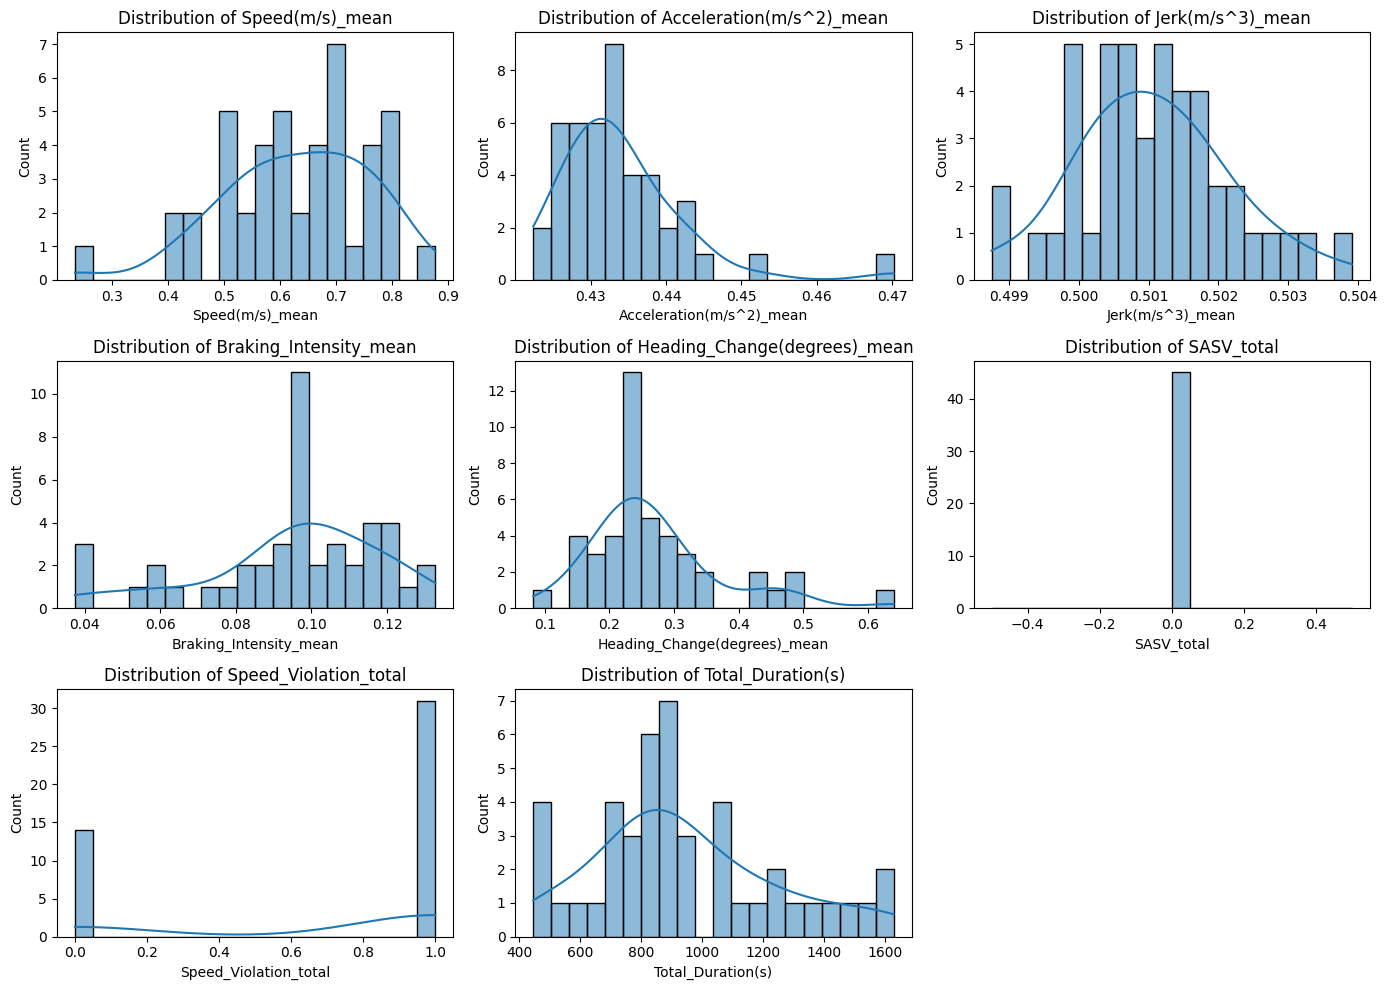

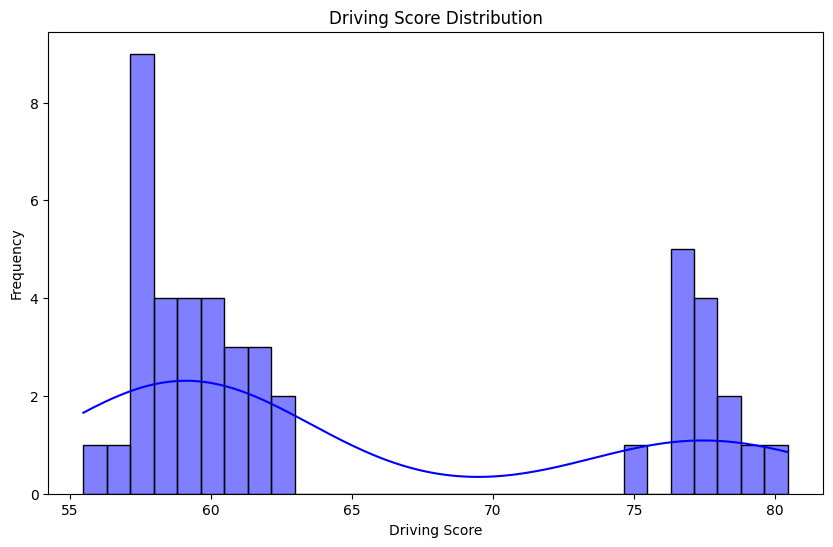

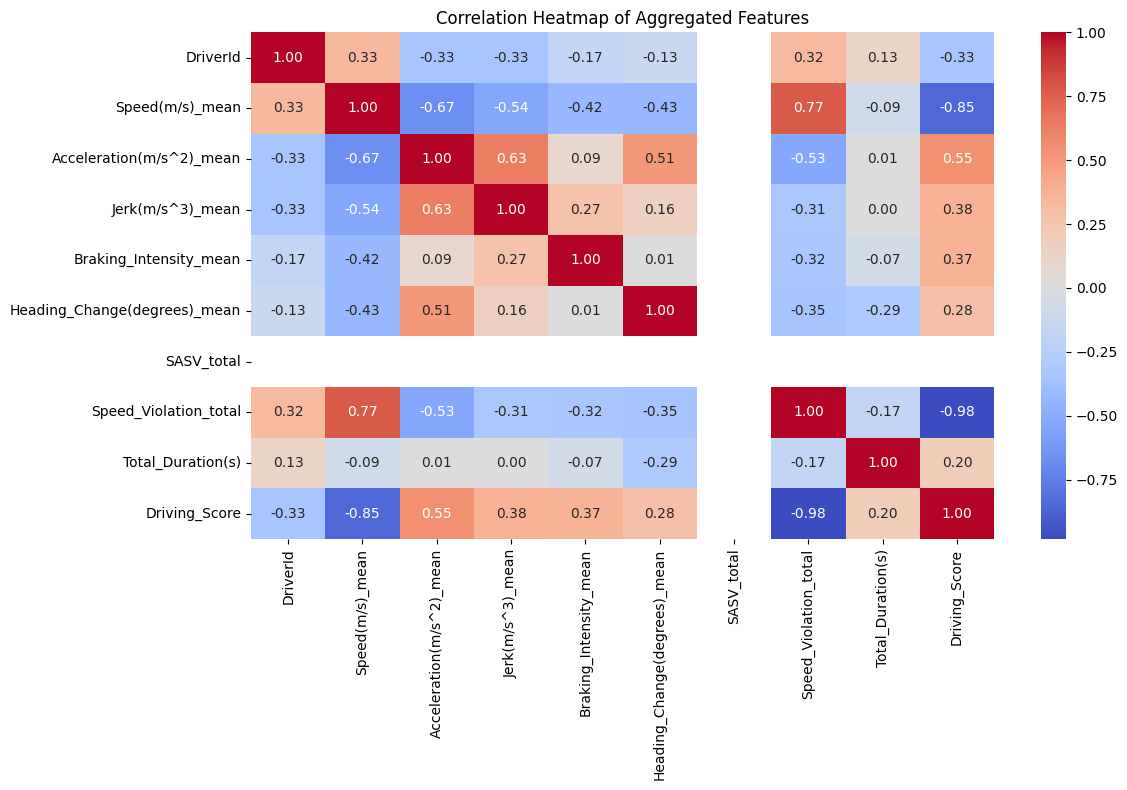

In [7]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure the 'data' directory exists
output_directory = 'data'
if not os.path.exists(output_directory):
    os.makedirs(output_directory)

# Load the processed trip-level data with timestamps
processed_data_path = '../data/processed_data.csv'
df = pd.read_csv(processed_data_path)

# Convert 'TimeStamp' to datetime format and derive 'DriverId' from 'TripID'
df['TimeStamp'] = pd.to_datetime(df['TimeStamp'])
df['DriverId'] = df['TripID'].apply(lambda x: int(x.split('-')[1]))

# Calculate time difference in seconds for each observation within each trip
df['Time_Diff'] = df.groupby('TripID')['TimeStamp'].diff().dt.total_seconds().fillna(0)

# ---------- Aggregation of Trip-Level Data to Driver-Level ---------- #
# Aggregate data by DriverId, calculating mean values for key features
driver_aggregated_data = df.groupby('DriverId').agg({
    'Speed(m/s)': 'mean',
    'Acceleration(m/s^2)': 'mean',
    'Jerk(m/s^3)': 'mean',
    'Braking_Intensity': 'mean',
    'Heading_Change(degrees)': 'mean',
    'SASV': lambda x: stats.mode(x, keepdims=True)[0][0],  # Mode for binary SASV
    'Speed_Violation': lambda x: stats.mode(x, keepdims=True)[0][0],  # Mode for binary Speed Violation
    'Time_Diff': 'sum'  # Total duration of trips per driver in seconds
}).reset_index()

# Rename columns to match bulk-level feature names for model
driver_aggregated_data.columns = [
    'DriverId', 'Speed(m/s)_mean', 'Acceleration(m/s^2)_mean', 'Jerk(m/s^3)_mean', 
    'Braking_Intensity_mean', 'Heading_Change(degrees)_mean', 'SASV_total', 
    'Speed_Violation_total', 'Total_Duration(s)'
]

# ---------- Driving Score Calculation ---------- #
# Initialize the Driving Score column with a base score of 100
driver_aggregated_data['Driving_Score'] = 100

# Apply penalties based on mean values of the features
driver_aggregated_data['Driving_Score'] -= driver_aggregated_data['Speed(m/s)_mean'] * 20  # Speed penalty
driver_aggregated_data['Driving_Score'] -= driver_aggregated_data['Acceleration(m/s^2)_mean'] * 15  # Acceleration penalty
driver_aggregated_data['Driving_Score'] -= driver_aggregated_data['Jerk(m/s^3)_mean'] * 5  # Jerk penalty
driver_aggregated_data['Driving_Score'] -= driver_aggregated_data['Braking_Intensity_mean'] * 5  # Braking intensity penalty
driver_aggregated_data['Driving_Score'] -= driver_aggregated_data['Heading_Change(degrees)_mean'] * 10  # Heading change penalty
driver_aggregated_data['Driving_Score'] -= driver_aggregated_data['SASV_total'] * 15  # Penalty for SASV
driver_aggregated_data['Driving_Score'] -= driver_aggregated_data['Speed_Violation_total'] * 15  # Penalty for speed violation

# Ensure the score is within the range [0, 100]
driver_aggregated_data['Driving_Score'] = driver_aggregated_data['Driving_Score'].clip(upper=100, lower=0)

# ---------- Driving Category Calculation ---------- #
# Function to categorize driving score into 'Safe', 'Moderate', or 'Risky'
def categorize_driving_score(score):
    if score > 75:
        return 'Safe'
    elif score > 60:
        return 'Moderate'
    else:
        return 'Risky'

# Apply the category function to create the Driving_Category column
driver_aggregated_data['Driving_Category'] = driver_aggregated_data['Driving_Score'].apply(categorize_driving_score)

# Save the aggregated data with Driving Category and Score
aggregated_data_path = '../data/driver_aggregated_data_with_category.csv'
driver_aggregated_data.to_csv(aggregated_data_path, index=False)

print(f"Aggregated data with driving score and category saved to {aggregated_data_path}.")

# ---------- Visualizations ---------- #

# Box Plot for aggregated features
plt.figure(figsize=(12, 6))
sns.boxplot(data=driver_aggregated_data.drop(columns=['DriverId', 'Total_Duration(s)', 'Driving_Score', 'Driving_Category']))
plt.title("Box Plot for Aggregated Driving Features (Post-Aggregation)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_directory, 'aggregated_features_boxplot.png'))
plt.show()

# Histograms for the aggregated features
numeric_columns = driver_aggregated_data.select_dtypes(include=[np.number]).columns.drop(['DriverId', 'Driving_Score'])

plt.figure(figsize=(14, 10))
for i, col in enumerate(numeric_columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(driver_aggregated_data[col], kde=True, bins=20)
    plt.title(f'Distribution of {col}')
plt.tight_layout()
plt.savefig(os.path.join(output_directory, 'aggregated_features_histograms.png'))
plt.show()

# Driving Score Distribution
plt.figure(figsize=(10, 6))
sns.histplot(driver_aggregated_data['Driving_Score'], bins=30, kde=True, color='blue')
plt.title("Driving Score Distribution")
plt.xlabel("Driving Score")
plt.ylabel("Frequency")
plt.show()

# Correlation heatmap of the aggregated features, excluding 'Driving_Category'
plt.figure(figsize=(12, 8))
corr_matrix = driver_aggregated_data.drop(columns=['Driving_Category']).corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Heatmap of Aggregated Features")
plt.tight_layout()
plt.savefig(os.path.join(output_directory, 'aggregated_features_correlation.png'))
plt.show()
